<a href="https://colab.research.google.com/github/minyongP/Python/blob/main/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 생성적 적대 신경망(Generative Adversarial Networks)[GAN]:
딥러닝의 원리를 이용하여 가상 이미지를 생성하는 알고리즘

- adversarial은 GAN 알고리즘을 잘 설명하는 단어; 생성자(Generator)와 판별자(Discriminator)이 적대적 경합을 하기 때문이다.



# DCGAN(Deep Convolutional GAN):
페이스북 AI 연구팀이 발표한 CNN을 GAN에 적용한 알고리즘

In [17]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Reshape, Activation, BatchNormalization, LeakyReLU, Conv2D, UpSampling2D
from keras.datasets import mnist

import matplotlib.pyplot as plt
import numpy as np

- 배치 정규화(Batch Normalization): 평균이 0, 분산이 1이 되도록 재배치하는 것


> 다음 층으로 입력될 값을 일정하게 재배치한다. 이를 통해 층의 개수가 늘어나도 안정적인 학습을 진행하게 한다.



In [18]:
# 생성자 모델
generator = Sequential()
generator.add(Dense(128*7*7, input_dim=100, activation=LeakyReLU(0.2)))   #
generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))                                       #(괄호 갯수 주의)
generator.add(UpSampling2D())                                             #(1)
generator.add(Conv2D(64, kernel_size=5, padding='same'))                  #
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(0.2)))
generator.add(UpSampling2D())                                             #(2)
generator.add(Conv2D(1, kernel_size=5, padding='same', activation='tanh'))# tanh는 -1 ~ 1

In [19]:
# 판별자 모델
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=5, strides=2, input_shape=(28,28,1), padding='same')) #
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=5, strides=2, padding='same'))
discriminator.add(Activation(LeakyReLU(0.2)))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer='adam')             #
discriminator.trainable = False                                                 #

In [20]:
# 생성자와 판별자 모델을 연결시키는 gan 모델
ginput = Input(shape=(100,))
dis_output = discriminator(generator(ginput))
gan = Model(ginput, dis_output)
gan.compile(loss='binary_crossentropy', optimizer='adam')
gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_10 (Sequential)  (None, 28, 28, 1)         865281    
                                                                 
 sequential_11 (Sequential)  (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


In [35]:
# 신경망 실행 함수
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기(앞서 사용한 MNIST 재사용, 테스트 과정은 필요 없고, 이미지만 사용하기에 X_train만 호출)
  (X_train,_), (_, _) = mnist.load_data()
  X_tain = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

  # 127.5를 뺀 후 127.5로 나누어 -1~1 사의 값으로 변경
  X_train = (X_train - 127.5) / 127.5

  true = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for i in range(epoch):
    # 실제 데이터를 판별자에 입력하는 부분
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    d_loss_real = discriminator.train_on_batch(imgs, true)

    # 가상 이미지를 판별자에 입력
    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)

    #판별자와 생성자의 오차 계산
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    g_loss = gan.train_on_batch(noise, true)

    print('epoch: %d' % i, 'd_loss: %.4f' % d_loss, 'g_loss:%.4f' % g_loss)

    # 중간 과정을 이미지로 저장하는 부분. (정해진 인터벌만큼 학습되면 그때 만든 이미지를 gan_images 폴더에 저장하라는 것)
    if i % saving_interval == 0:
    # r, c = 5, 5
      noise = np.random.normal(0, 1, (25, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5
    fig, axs = plt.subplots(5, 5)
    count = 0
    for j in range(5):
      for k in range(5):
        axs[j, k].imshow(gen_imgs[count,:,:,0], cmap='gray')
        axs[j, k].axis('off')
        count += 1
    fig.savefig("gan_images/gan_mnist_%d.png" % i)

1/1 [==============================] - 0s 87ms/step
epoch: 0 d_loss: 0.5022 g_loss:0.2861
1/1 [==============================] - 0s 73ms/step


FileNotFoundError: ignored

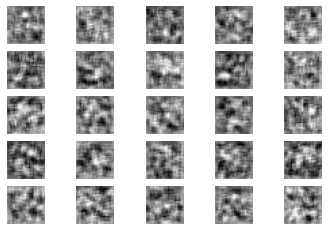

In [37]:
# 2000번 반복(+1주의), 배치 크기는 32, 200번마다 결과 저장
gan_train(2001, 32, 200)